In [134]:
# Import Stuff
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Load Data

In [148]:
# Load Data
data_1_4 = pd.read_csv("A1 data - data_1_4.csv")
data_2_12 = pd.read_csv("A1 data - data_2_12(1).csv")
data_3_12 = pd.read_csv("A1 data - data_3_12(1).csv")
data_2_8 = pd.read_csv("A1 data - data_2_8.csv")
data_compo = pd.read_csv("A1 data - data_com.csv")

In [149]:
# Get trials 
trials_data_1_4 = {}
trials_data_2_12 = {}
trials_data_3_12 = {}
trials_data_2_8 = {}
for i in range(1, 4):
    trials_data_1_4[f"trials_{i}_data_1_4"] = data_1_4.loc[:, f'T{i}':f'Remaining{i}']
    trials_data_2_12[f"trials_{i}_data_2_12"] = data_2_12.loc[:, f'T{i}':f'Remaining{i}']
    trials_data_3_12[f"trials_{i}_data_3_12"] = data_3_12.loc[:, f'T{i}':f'Remaining{i}']
    trials_data_2_8[f"trials_{i}_data_2_8"] = data_2_8.loc[:, f'T{i}':f'Remaining{i}']

# For the composite there are only 1 trials each
one_decay = data_compo.loc[:, 'T_1d':'Remaining_1d']
two_decay = data_compo.loc[:, 'T_2d':'Remaining_2d']

In [150]:
# Process data
def standardize_and_combine(trials_dict):

    standardized_dfs = []  
    for trial_name, df in trials_dict.items():
        time_col = [col for col in df.columns if col.startswith("T")][0]  
        remaining_col = [col for col in df.columns if "Remaining" in col][0]  
        df = df.rename(columns={time_col: "Time", remaining_col: f"Remaining_{trial_name}"})
        standardized_dfs.append(df)
        
    combined_df = standardized_dfs[0]
    for df in standardized_dfs[1:]:
        combined_df = pd.merge(combined_df, df, on="Time", how="outer")

    remaining_cols = [col for col in combined_df.columns if col.startswith("Remaining_")]
    combined_df["Remaining_Mean"] = combined_df[remaining_cols].mean(axis=1, skipna=True)
    combined_df["Remaining_Std"] = combined_df[remaining_cols].std(axis=1, skipna=True)

    return combined_df

combined_df_1_4 = standardize_and_combine(trials_data_1_4)
combined_df_2_8 = standardize_and_combine(trials_data_2_8)
combined_df_2_12 = standardize_and_combine(trials_data_2_12)
combined_df_3_12 = standardize_and_combine(trials_data_3_12)

### Setup Simulation

In [151]:
# Number of Dice
N = 10000
data = {}
    
def run(N, D_type, no_decay_states, data):
    faces_states = list(range(1, D_type+1))
    decay_states = [i for i in range(1, no_decay_states + 1)]
    time = 0
    array_time = [0]
    array_N = [10000]
    while N > 0:
        time += 1
        # Randomize choice
        dices = [np.random.choice(faces_states) for i in range(N)]
        # Remove dices
        dices = [face for face in dices if face not in decay_states]
        N = len(dices)
        # Append Data
        array_time.append(time)
        array_N.append(N)
    data[f"P = {no_decay_states/D_type}"] = (array_time, array_N)

# Run all types
run(N, 4, 1, data)
run(N, 8, 2, data)
run(N, 12, 2, data)
run(N, 12, 3, data)
run(N, 100, 1, data)
run(N, 100, 50, data)

### Plot Data (Experimental)

In [152]:
def find_half_life(time, N):
    time = np.array(time)
    N = np.array(N)

    N0 = N[0]
    N_half = N0 / 2  # Half of initial value

    # Find the indices where N crosses N_half
    above_half = N > N_half
    below_half = N < N_half

    if np.all(above_half):  
        print("N never reaches half its initial value.")
        return None
    elif np.all(below_half):  
        print("N is always below half its initial value.")
        return None

    # Find the first index where N goes below N_half
    for i in range(len(N) - 1):
        if above_half[i] and below_half[i + 1]:  # Transition point
            # Linear interpolation: t_half = t1 + (t2 - t1) * (N_half - N1) / (N2 - N1)
            t1, t2 = time[i], time[i + 1]
            N1, N2 = N[i], N[i + 1]

            t_half = t1 + (t2 - t1) * (N_half - N1) / (N2 - N1)
            return t_half

    return None  # Just in case

In [158]:
from scipy.optimize import curve_fit
def theo(time, P):
    """ 
    This is the exponential expected distribution
    """
    lambda_theo = P
    return 100*np.exp(-lambda_theo*time)
def geo_theo(P, EX):
    time = []
    N_remains = []
    N_theo = []
    N = 100
    counter = 0
    while N >= 1 and counter <= EX:
        time.append(counter)
        N_remains.append(N)
        N_theo.append(theo(counter, P))
        counter += 1
        N = int((1-(P))*N)
    return N_theo, N_remains, time
def model_geo(t, P):
    return ((1 - P) ** np.array(t)) * 100
def model_expo(t, P):
    return 100*np.exp(-P*t)
def plot_combined_decay(combined_df, P = 0.25, title = ""):
    """
    Plots the mean remaining dice with standard deviation as a shaded region.

    Parameters:
    combined_df (pd.DataFrame): The processed DataFrame with mean and std.
    """
    plt.figure(figsize=(10, 5))
    
    # Plot mean remaining dice
    plt.plot(combined_df["Time"], combined_df["Remaining_Mean"], marker='o', linestyle='-', color='b', label="Experimental Data")
    
    # Remove rows where 'Remaining_Mean' is NaN or Inf
    cleaned_df = combined_df[~combined_df["Remaining_Mean"].isna()]
    cleaned_df = cleaned_df[~np.isinf(cleaned_df["Remaining_Mean"])]

    time_to_model = cleaned_df["Time"]
    observed_to_model = cleaned_df["Remaining_Mean"]
    popt_geo, _ = curve_fit(model_geo, time_to_model, observed_to_model, p0=[P])  # Initial guess for P
    popt_expo, _ = curve_fit(model_expo, time_to_model, observed_to_model, p0=[P])  # Initial guess for P

# Extract the estimated P
    P_geo = popt_geo[0]
    P_expo = popt_expo[0]
    print(f"Estimated for P = {P}:  P_geo: {P_geo}, P_expo: {P_expo}")
    
    #Half life of the data using interpolation
    print("Half life: ", find_half_life(cleaned_df["Time"], cleaned_df["Remaining_Mean"]))
    
    
    # Plot shaded standard deviation area
    plt.fill_between(combined_df["Time"],
                     combined_df["Remaining_Mean"] - combined_df["Remaining_Std"],
                     combined_df["Remaining_Mean"] + combined_df["Remaining_Std"],
                     color='b', alpha=0.2)

    
    N_theo, N_geo, time = geo_theo(P, len(combined_df['Time']))
    
    plt.plot(time, N_geo, marker = "+",label="Geometric")
    plt.plot(time, N_theo, marker = "x", label ="Exponential")
#     plt.semilogy()
    plt.xlabel("Time")
    plt.ylabel("Remaining Dice (N)")
    plt.title(f"Remaining Dice vs Time for P = {P:3f} [{title}]")
    plt.legend()
#     plt.semilogx()
    plt.grid(True)
    plt.show()


Estimated for P = 0.25:  P_geo: 0.24277027173670485, P_expo: 0.27808857442253143
Half life:  2.3902439024390243


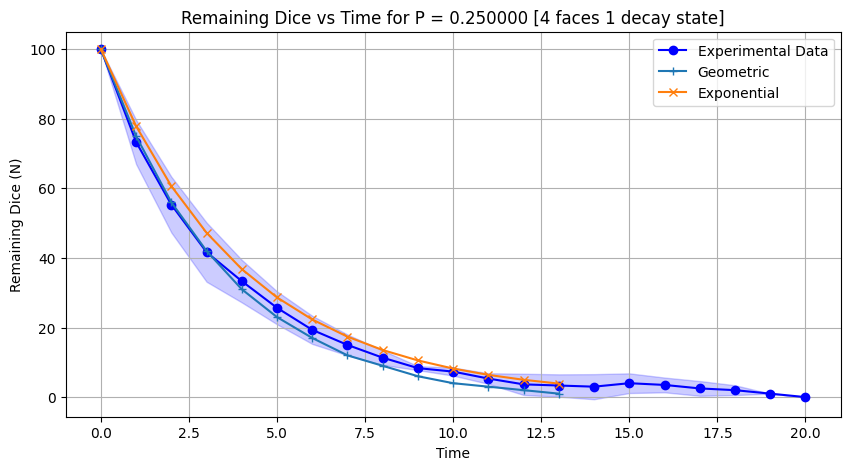

In [159]:
plot_combined_decay(combined_df_1_4, P = 1/4, title ="4 faces 1 decay state")

Estimated for P = 0.25:  P_geo: 0.18269208835152853, P_expo: 0.20173937133864056
Half life:  3.4594594594594597


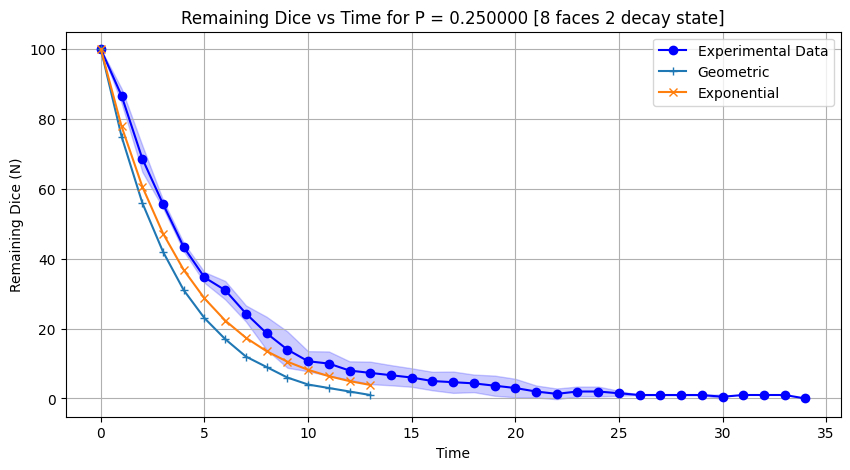

In [160]:
plot_combined_decay(combined_df_2_8, P = 2/8, title ="8 faces 2 decay state")

Estimated for P = 0.16666666666666666:  P_geo: 0.16965944653676157, P_expo: 0.18591935499724568
Half life:  3.896551724137931


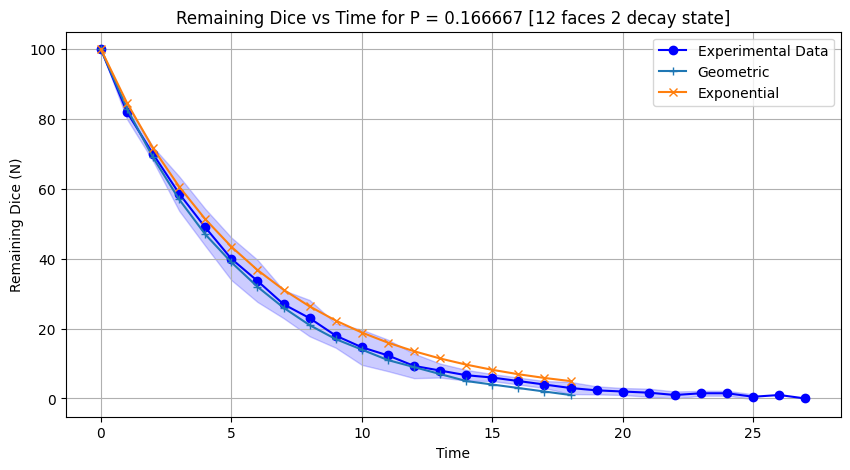

In [161]:
plot_combined_decay(combined_df_2_12, P = 2/12, title ="12 faces 2 decay state")

Estimated for P = 0.25:  P_geo: 0.21678069912851272, P_expo: 0.2443425352943399
Half life:  2.8857142857142857


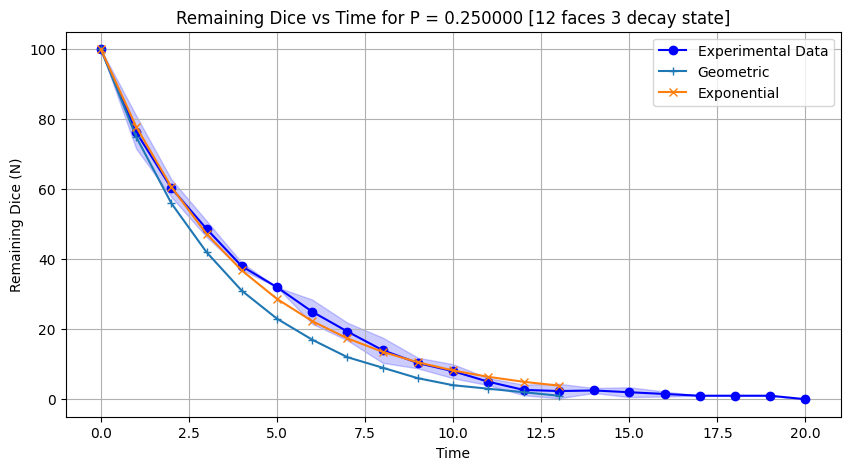

In [162]:
plot_combined_decay(combined_df_3_12, P = 3/12, title ="12 faces 3 decay state")

In [146]:
print(combined_df_3_12.describe())

            Time   Removed1  Remaining_trials_1_data_3_12   Removed2  \
count  21.000000  21.000000                     21.000000  14.000000   
mean   10.000000   4.761905                     21.333333   7.142857   
std     6.204837   6.378909                     28.450542   7.522859   
min     0.000000   0.000000                      0.000000   0.000000   
25%     5.000000   0.000000                      1.000000   2.250000   
50%    10.000000   1.000000                      8.000000   4.500000   
75%    15.000000   7.000000                     32.000000  10.250000   
max    20.000000  22.000000                    100.000000  29.000000   

       Remaining_trials_2_data_3_12   Removed3  Remaining_trials_3_data_3_12  \
count                     14.000000  21.000000                     21.000000   
mean                      30.214286   4.761905                     22.523810   
std                       30.000458   5.948990                     28.664646   
min                        0.00

In [147]:
print(combined_df_2_8.describe())

            Time   Removed1  Remaining_trials_1_data_2_8   Removed2  \
count  21.000000  21.000000                    21.000000  14.000000   
mean   10.000000   4.761905                    21.333333   7.142857   
std     6.204837   6.378909                    28.450542   7.522859   
min     0.000000   0.000000                     0.000000   0.000000   
25%     5.000000   0.000000                     1.000000   2.250000   
50%    10.000000   1.000000                     8.000000   4.500000   
75%    15.000000   7.000000                    32.000000  10.250000   
max    20.000000  22.000000                   100.000000  29.000000   

       Remaining_trials_2_data_2_8   Removed3  Remaining_trials_3_data_2_8  \
count                    14.000000  21.000000                    21.000000   
mean                     30.214286   4.761905                    22.523810   
std                      30.000458   5.948990                    28.664646   
min                       0.000000   0.000000   

### Plot Data (Simulation

In [163]:
def theo(time, P):
    """ 
    This is the exponential expected distribution
    """
    lambda_theo = P
    return 10000*np.exp(-lambda_theo*time)
def geo_non_discrete(time, P):
    print(time)
    print(P)
    return ((1-P)**np.array(time))*10000
def geo_theo(P, EX):
    time = []
    N_remains = []
    N_theo = []
    N = 10000
    counter = 0
    while N >= 1 and counter <= EX:
        time.append(counter)
        N_remains.append(N)
        N_theo.append(theo(counter, P))
        counter += 1
        N = int((1-(P))*N)
    return N_theo, N_remains, time

def plot_combined_decay(combined_df, P = 0.25, title = ""):
    """
    Plots the mean remaining dice with standard deviation as a shaded region.

    Parameters:
    combined_df (pd.DataFrame): The processed DataFrame with mean and std.
    """
    plt.figure(figsize=(10, 5))
    
    # Plot mean remaining dice
    plt.plot(combined_df["Time"], combined_df["Remaining_Mean"], marker='o', linestyle='-', color='b', label="Experimental Data")

    # Plot shaded standard deviation area
    plt.fill_between(combined_df["Time"],
                     combined_df["Remaining_Mean"] - combined_df["Remaining_Std"],
                     combined_df["Remaining_Mean"] + combined_df["Remaining_Std"],
                     color='b', alpha=0.2)

    
    N_theo, N_geo, time = geo_theo(P, len(combined_df['Time']))
    
    plt.plot(time, N_geo, marker = "+",label="Geometric")
    plt.plot(time, N_theo, marker = "x", label ="Exponential")
#     plt.semilogy()
    plt.xlabel("Time")
    plt.ylabel("Remaining Dice (N)")
    plt.title(f"Remaining Dice vs Time for P = {P:3f} [{title}]")
    plt.legend()
#     plt.semilogx()
    plt.grid(True)
    plt.show()

In [168]:
def plot_sim(simul, P, title = ""):
    time_prop = simul[0]
    N_data = simul[1]
    N_theo, N_geo, time = geo_theo(P, len(time_prop))
    plt.plot(time_prop, N_data, marker = "o", label = "Simulated Data")
#     plt.plot(time_prop, geo_non_discrete(time_prop, P), marker = "x", label = "test")
    plt.plot(time, N_geo, marker = "+",label="Geometric")
    plt.plot(time, N_theo, marker = "x", label ="Exponential")
    plt.xlabel("Time")
    plt.ylabel("Remaining Dice (N)")
    plt.title(f"Remaining Dice vs Time for P = {P:3f} [{title}]")
    plt.legend()
#     plt.semilogx()
    plt.grid(True)
    plt.show()

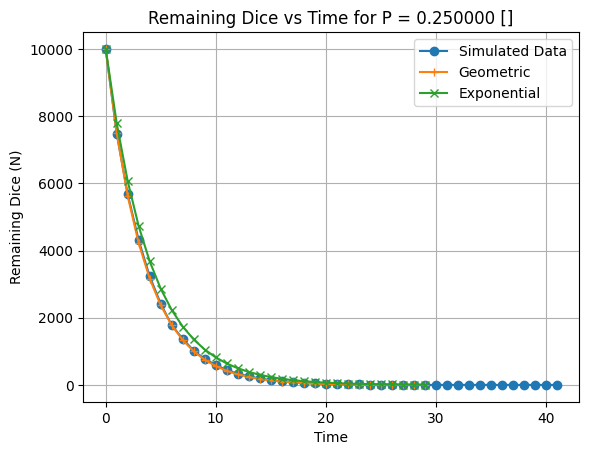

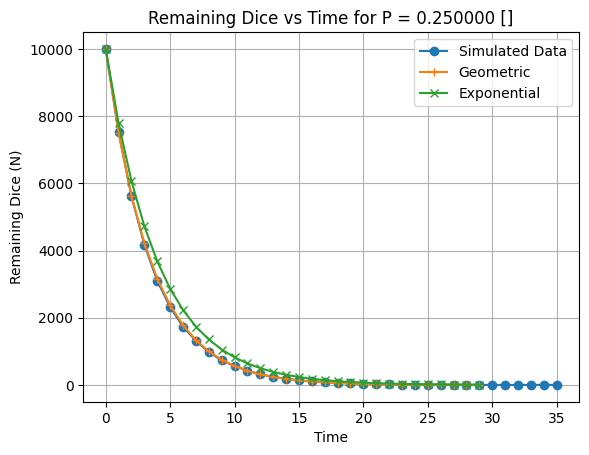

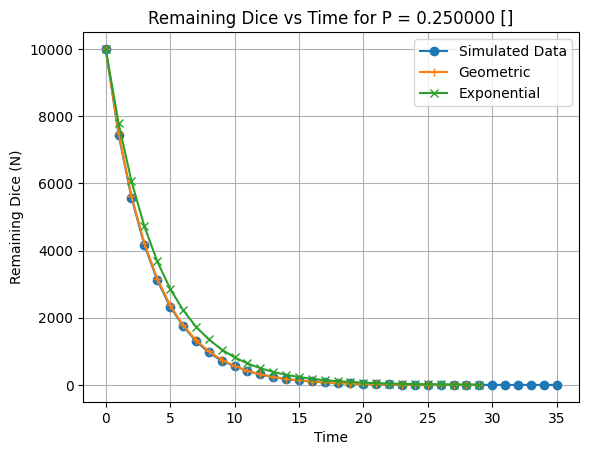

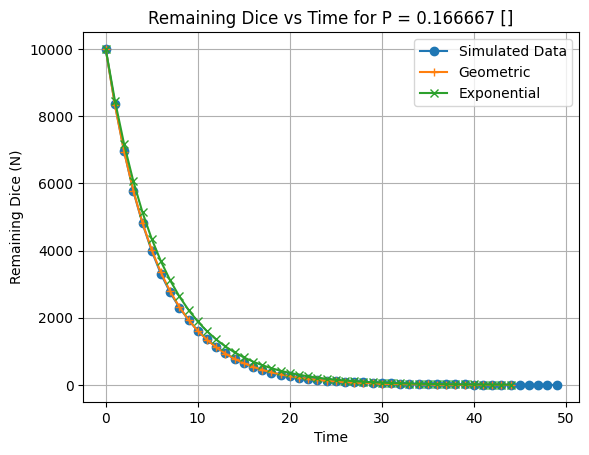

In [169]:
run(N, 4, 1, data)
plot_sim(data[f"P = {1/4}"], 1/4)

run(N, 8, 2, data)
plot_sim(data[f"P = {2/8}"], 2/8)

run(N, 12, 3, data)
plot_sim(data[f"P = {3/12}"], 3/12)

run(N, 12, 2, data)
plot_sim(data[f"P = {2/12}"], 2/12)

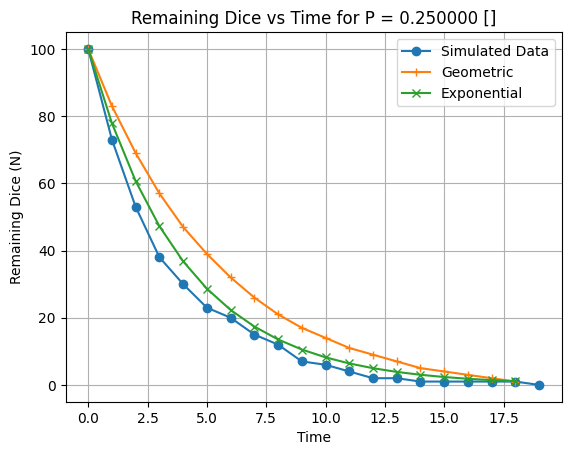

In [13]:
plot_sim(data[f"P = {2/8}"], 2/8)

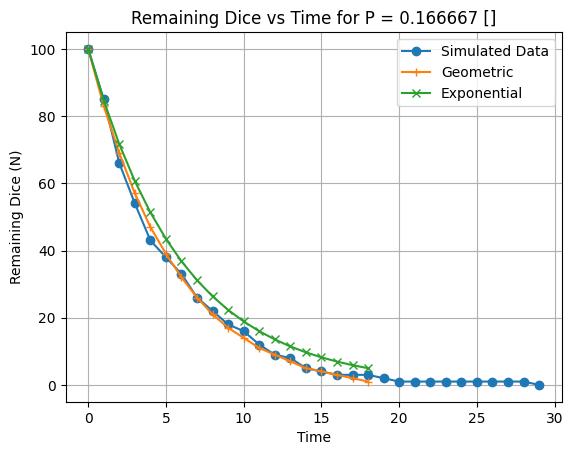

In [14]:
plot_sim(data[f"P = {2/12}"], 2/12)

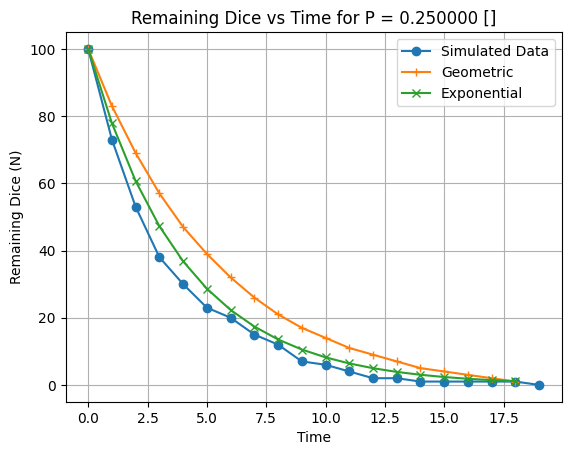

In [15]:
plot_sim(data[f"P = {3/12}"], 3/12)